# Image reconstruction in X-ray tomography
* Authors: Mengda Li, Ségolène Martin

## 1. X-ray tomography

The measurements $y \in R^M$ and the sought absorption image $\bar{x} \in R^N$ obey the linear relation:
$$y = H \bar{x} + w\tag{1}$$
where $w ∈ R^M$ is the measurement noise, that we assume i.i.d. Gaussian with variance $σ^2$. The tomography matrix $H ∈R^{M×N}$ is sparse and encodes the geometry of the measurements.

1. Download the projection matrix $H$ and the image $\bar{x}$ available on the website. Use `loadmat` from `scipy.io` in Python to load the arrays, note that $H$ is stored as a sparse matrix. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from pathlib import Path
p = Path('data')
MATRICES = dict()
for matrix in p.iterdir():
    matrix_name = matrix.name[0]
    MATRICES[matrix_name] = sio.loadmat(matrix)

H = MATRICES['H']['H']
x = MATRICES['x']['x']

2. Construct $y$, according to model (1), using $σ = 1$.

In [3]:
# sigma = 1
M, N = H.shape
w = np.random.normal(size = (M, 1))
y = H * x + w

3. Here, $N = 90×90$ pixels and $M = 90×180$ measurements. Display a 2D version of $x$ and a 2D version of $y$, also known as sinogram.

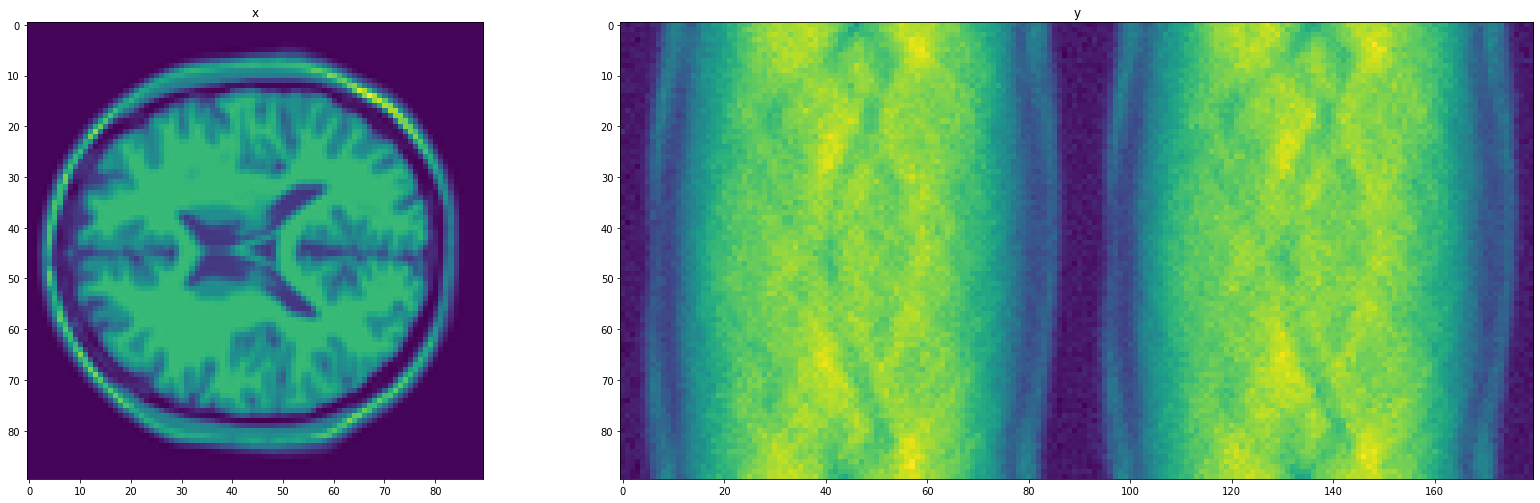

In [4]:
# plt.figure(figsize = (27,9))
plt.rcParams["figure.figsize"] = (27,9)
_, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 2]})
a0.imshow(np.reshape(x, (90, 90)))
a0.set_title('x')
a1.imshow(np.reshape(y, (90, 180)))
a1.set_title('y');

## 2. Optimization problem

An eﬃcient strategy to address the reconstruction problem is to deﬁne $x $as a minimizer of an appropriate cost function $f$. More speciﬁcally, we focus on the following penalized least-squares criterion :
$$\forall x  ∈R^N, \ f(x) =
\frac{1}{2}∥Hx−y∥^2 + λr(x) \tag{2} $$

where $r$ is a regularization function incorporating a priori assumptions to guarantee the robustness of the solution with respect to noise. In order to promote images formed by smooth regions separated by sharp edges, we set
$$∀x ∈R^N, \ r(x) =
 ∑^{2N}_{n=1}
ψ([Gx]^{(n)}) \tag{3}
$$

where $G ∈R^{2N×N}$ is a sparse matrix such that $Gx ∈R^{2N}$ is the concatenation of the horizontal and vertical gradients of the image, and $ψ$ is a potential function deﬁned as : 
$$∀u ∈R, \ ψ(u) =\sqrt{1 + u^2/δ^2}  \tag{4}$$
with some parameter $δ > 0$ aiming at guaranteeing the diﬀerentiability of $r$. In the following, we will set $(λ,δ) = (0.13,0.02)$.

1. Download the gradient operator $G$ available in the website.

In [5]:
G = MATRICES['G']['G']

2. Give the expression of the gradient $∇f$ at some point $x ∈ R^N$. Create a function which gives as an output the gradient of $f$ at some input vector $x$.

<!-- In fact, the gradient $\nabla f$ here is the jacobian of $f$. -->
$$\nabla{f}(x) = H^TH x - H^Ty + \lambda \nabla{r}(x)$$
Let ${(e_n)_{n \in [1 .. 2N]}}$ be the canonical vector basis in $\mathbb{R}^{2N}$, 

<!-- $$
\begin{aligned}
 AR(p): Y_i &= c + \epsilon_i + \phi_i Y_{i-1} \dots \\
 Y_{i} &= c + \phi_i Y_{i-1} \dots
\end{aligned}
$$
$$\nabla r(x)^T = \sum_{n = 1}^{2N} \psi'(e_n^T G x) e_n^T G $$ -->

$$
\begin{aligned}
r(x) &= \sum_{n = 1}^{2N} \psi(e_n^T G x) \\
\nabla r(x)^T &= \sum_{n = 1}^{2N} \psi'(e_n^T G x) e_n^T G
\end{aligned}
$$
where $\psi'(u) = \frac{u}{\delta^2 \sqrt{1+\frac{u^2}{\delta^2} }}$.

so $$\nabla{f}(x)^T = x^T H^TH - y^TH + 
\lambda \sum_{n = 1}^{2N}\frac{e_n^T G x}{\delta^2 \sqrt{1+\frac{(e_n^T G x)^2}{\delta^2} }} e_n^T G $$
$$
\nabla{f}(x) = H^TH x - H^Ty + 
\lambda \sum_{n = 1}^{2N}\frac{[G x]^{(n)}}{\delta^2 \sqrt{1+\frac{([G x]^{(n)})^2}{\delta^2} }} [G]^{(n)}
$$
where $[G]^{(n)}$ is the vector of the $n$-th row of $G$.

In [35]:
LAMBDA, DELTA = 0.13, 0.02
DELTA2 = DELTA**2
Hy = H.T * y
HH = H.T * H

def grad_f(x):
    def grad_r(x):
        def dev_psi(u: np.array):
            return u / (DELTA2 * np.sqrt(1 + u**2 / DELTA2))
        Gx = G * x
#         vec =  Gx / (DELTA2 * np.sqrt(1 + Gx**2 / DELTA2))
        return G.T * dev_psi(Gx) #dev_psi(Gx).T * G
#     return HH * x - Hy + LAMBDA * grad_r(x)
    return H.T*(H*x) - Hy + LAMBDA * grad_r(x)

3. Show that a Lipschitz constant of $∇f$ is
$$L = ∥H∥^2 + (\lambda / \delta^2) ∥G∥^2$$
Calculate it for the $(\lambda, \delta^2)$ values given above. Note that,  in Python, the function
`scipy.sparse.linalg.svds` gives the singular values of a sparse matrix, the
maximal singular value being the norm of the matrix.

_*!*_ To do the proof.. (ref slide 11? -MM), la def de norm avec vector norm <=1

In [7]:
from scipy.sparse.linalg import svds
L = svds(H, k = 1)[1] + (LAMBDA/DELTA2) * svds(G, k = 1)[1]

## 3. Optimization algorithms

### 3.1 Gradient descent algorithm

1. Create $x_0 \in R^N$ a vector with all entries equal to $0$. This will be our initialization for all tested algorithms.

In [8]:
x_0 = np.zeros((N, 1)) 

2. Implement a gradient descent algorithm to minimize $f$.

critere darret 3.6

In [ ]:
def line_search(f,
                x: "starting point in the feasible domain of f",
                Delta_x: "descent direction",
                gradient_f_x: "gradient of f at x",
                a: "affinity of approximation" = 0.25,
                b: "decreasing rate" = 0.5
    ) -> "step size":
    """Backtracking line search."""
    t = 1
    while f(x + t*Delta_x) > f(x) + a*t*gradient_f_x @ Delta_x:
        t = b*t
    return t

def grad_descent(
        f: "convex function to be minimized",
        x: "starting point in the strictly feasible domain of f",
        e: "tolerance, >0",
        gradient_f: "function to compute the gradient of f at some point x",
        a: "line search parameter, affinity of approximation" = 0.25,
        b: "line search parameter, decreasing rate" = 0.5
    ) -> "argmin f":
    """Gradient descent method."""
    while True:
        Grad_f_x = gradient_f(x)

        search_direction = - newton_step

        t = line_search(f, x, newton_direction, Grad_f_x, a, b)
        x = x + t*newton_direction
        
def f(x):
    pass

### 3.2 MM quadratic algorithm

1. Construct, for all $x \in R^N$, a quadratic majorant function of $f$ at $x$. Create
a function which gives, as an output, the curvature $A(x)$ of the majorant
function at an input vector $x$.

Hint :  in Python,
use `scipy.sparse.diags(d[:,0]).tocsc()` to create a sparse matrix from a
diagonal vector $d \in R^{n \times 1}$ using the compressed sparse column format. In addition, in Python, use the class `LinearOperator` from `scipy.sparse.linalg`
to create the curvature operator.

In [45]:
from scipy.sparse import diags
from scipy.sparse.linalg import LinearOperator
from functools import partial

def A(x):
    def Delta(u: np.array):
        def dev_psi_div_u(u: np.array):
            return 1 / (DELTA2 * np.sqrt(1 + u**2 / DELTA2))
        flatten = (dev_psi_div_u(u)).reshape(2*N)
        return diags(flatten)
    Gx = G * x
    def Ax_u(Gx, u):
        return H.T*(H*u) + LAMBDA * G.T * (Delta(Gx) * (G * u))
    matvec = partial(Ax_u, Gx)
    
    return LinearOperator((N, N), matvec = matvec, rmatvec = matvec)

2. Deduce a MM quadratic algorithm to minimize $f$. Implement it.

Hint : in
Python, use `bicg` from `scipy.sparse.linalg`.

In [48]:
from scipy.sparse.linalg import bicg

def MM_step(x):
    b = grad_f(x)
#     A = A(x)
    return -bicg(A(x), b)[0]